In [ ]:
!pip -q install -U "transformers==4.44.2" "datasets==2.21.0" "accelerate==0.33.0"
import os; os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ope

In [ ]:
# ▶️ Phi-3-mini (fp16, no bitsandbytes, no triton) for SAT/UNSAT on syllogistic fragments
# Upload your CSV when prompted. GPU runtime recommended (T4 is fine).

# ===== Minimal deps (no bitsandbytes) =====
!pip -q install -U "transformers==4.46.1" "accelerate==0.34.2" sentencepiece safetensors

# ===== Config =====
LM_NAME            = "microsoft/Phi-3-mini-4k-instruct"   # 3.8B instruct model
PIN_REV            = None  # optional: e.g., "refs/pr/..." or a commit hash to pin; leave None to use latest
FEWSHOT_K_PER_CLS  = 4     # shots per class (total 2*K few-shot examples)
VOTES              = 3     # build VOTES different few-shot sets and majority-vote
TEMPERATURE        = 0.1
TOP_P              = 0.95
TEXT_MAX_LEN_CHARS = 1800  # cap very long fragments for the prompt
RANDOM_STATE       = 42
CLASS_NAMES        = ["unsat","sat"]
SEP_TOKEN          = "[SEP]"

# from google.colab import files
# uploaded = files.upload()
CSV_NAME = "syllogistic.csv"

# ===== Imports =====
import torch, random, re, ast, json, shutil
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score
from transformers import AutoTokenizer, AutoModelForCausalLM

OUTDIR = Path("phi3_fp16_run"); OUTDIR.mkdir(parents=True, exist_ok=True)

# ===== Helpers =====
def normalize_label(v):
    if isinstance(v,str):
        s=v.strip().lower()
        if s in {"sat","satisfiable","1","true"}: return 1
        if s in {"unsat","unsatisfiable","0","false"}: return 0
    if isinstance(v,(int,np.integer)) and v in (0,1): return int(v)
    raise ValueError(f"Bad label: {v}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                L = ast.literal_eval(s)
                if isinstance(L, list) and all(isinstance(x,str) for x in L):
                    return f" {sep} ".join(L)
            except: pass
        return s
    return str(cell)

def truncate_text(t, max_chars=TEXT_MAX_LEN_CHARS):
    t = str(t);  return (t[:max_chars] + " …") if len(t) > max_chars else t

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        rs = cm_plot.sum(axis=1, keepdims=True); rs[rs==0]=1.0
        cm_plot = cm_plot/rs
    plt.figure(figsize=(4.6,4.2))
    im = plt.imshow(cm_plot, cmap="Blues", aspect="equal")
    plt.title(title); plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
    thr = cm_plot.max()/2 if cm_plot.max()>0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i,j]:.2f}" if normalize else f"{int(cm_plot[i,j])}"
            plt.text(j,i,val,ha="center",va="center",color="white" if cm_plot[i,j]>thr else "black",fontsize=11)
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

def build_fewshot(X, y, k_per_cls=3, seed=RANDOM_STATE):
    rng = random.Random(seed)
    idx0 = [i for i,t in enumerate(y) if t==0]
    idx1 = [i for i,t in enumerate(y) if t==1]
    rng.shuffle(idx0); rng.shuffle(idx1)
    shots=[]
    for i in idx0[:k_per_cls]: shots.append((X[i], "A"))  # A = unsat
    for i in idx1[:k_per_cls]: shots.append((X[i], "B"))  # B = sat
    rng.shuffle(shots)
    return shots

def make_messages(fewshot, fragment):
    sys_msg = (
        "You are a formal-logic classifier. Decide if a fragment is UNSATISFIABLE or SATISFIABLE.\n"
        "Use a forced choice: A = unsat, B = sat.\n"
        "Reply with exactly one character: 'A' or 'B'. No explanation."
    )
    messages = [{"role":"system","content":sys_msg}]
    for s, lab in fewshot:
        messages.append({"role":"user","content": f"Fragment:\n{truncate_text(s)}\n\nAnswer (A or B):"})
        messages.append({"role":"assistant","content": lab})
    messages.append({"role":"user","content": f"Fragment:\n{truncate_text(fragment)}\n\nAnswer (A or B):"})
    return messages

def ab_to_label(ab):
    return 0 if ab == "A" else 1 if ab == "B" else None

# ===== Load data =====
df = pd.read_csv(CSV_NAME)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
assert label_col is not None and "sentences" in df.columns, "CSV must have 'sentences' and 'sat'/'label'."

df["y"]    = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

X_train, X_val, y_train, y_val = train_test_split(
    df["text"].tolist(), df["y"].to_numpy(),
    test_size=0.2, stratify=df["y"].to_numpy(), random_state=RANDOM_STATE
)
print(f"Train={len(X_train)} | Val={len(X_val)} | Val sat rate={np.mean(y_val):.3f}")

# ===== Load Phi-3 in fp16 (no bnb, no triton) =====
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32

tok = AutoTokenizer.from_pretrained(LM_NAME, use_fast=True, revision=PIN_REV) if PIN_REV else AutoTokenizer.from_pretrained(LM_NAME, use_fast=True)
if tok.pad_token_id is None: tok.pad_token_id = tok.eos_token_id

# Force eager attention to avoid Triton/flash-attn, and no quantization
if PIN_REV:
    model = AutoModelForCausalLM.from_pretrained(
        LM_NAME, revision=PIN_REV,
        torch_dtype=dtype, device_map="auto" if device=="cuda" else None,
        attn_implementation="eager"
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        LM_NAME,
        torch_dtype=dtype, device_map="auto" if device=="cuda" else None,
        attn_implementation="eager"
    )

def run_one(messages, max_new_tokens=2, temperature=TEMPERATURE, top_p=TOP_P):
    # Use chat template if available
    try:
        prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except Exception:
        prompt = "\n\n".join([f"[{m['role'].upper()}]\n{m['content']}" for m in messages] + ["[ASSISTANT]\n"])
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=(temperature > 0),
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
        )
    gen = tok.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
    m = re.search(r"\b([AB])\b", gen)
    return m.group(1) if m else None

# ===== Evaluate with few-shot + voting =====
FEWSHOT_K = FEWSHOT_K_PER_CLS
seeds = [42, 777, 2025][:VOTES]

preds = []
for i, frag in enumerate(X_val):
    votes = []
    for s in seeds:
        shots = build_fewshot(X_train, y_train, k_per_cls=FEWSHOT_K, seed=s + i)  # vary per item
        ab = run_one(make_messages(shots, frag))
        lab = ab_to_label(ab)
        votes.append(1 if lab is None else lab)  # default to sat (B) if parse fails
    pred = int(round(sum(votes)/len(votes)))
    preds.append(pred)
    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(X_val)}")

# ===== Report + plots =====
print("\nValidation report — Phi-3-mini (fp16, few-shot A/B + vote):")
print(classification_report(y_val, preds, digits=4, target_names=CLASS_NAMES))
cm = confusion_matrix(y_val, preds, labels=[0,1])
plot_cm(cm, CLASS_NAMES, "Phi-3-mini — Confusion (counts)", normalize=False, save_path=OUTDIR/"cm_phi3_counts.png")
plot_cm(cm, CLASS_NAMES, "Phi-3-mini — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/"cm_phi3_normalized.png")

with open(OUTDIR/"phi3_report.json","w") as f:
    json.dump({
        "model": LM_NAME,
        "fewshot_k_per_class": int(FEWSHOT_K_PER_CLS),
        "votes": int(VOTES),
        "metrics": {
            "accuracy": accuracy_score(y_val, preds),
            "f1_macro": f1_score(y_val, preds, average="macro", zero_division=0),
            "precision_macro": precision_recall_fscore_support(y_val, preds, average="macro", zero_division=0)[0],
            "recall_macro":    precision_recall_fscore_support(y_val, preds, average="macro", zero_division=0)[1],
        },
        "confusion_matrix": cm.tolist()
    }, f, indent=2)

# Zip outputs
zip_path = shutil.make_archive("phi3_fp16_run", "zip", root_dir=OUTDIR)
print(f"\nZipped outputs at: {zip_path}")
try:
    files.download(zip_path)
except:
    print("Use the Files pane to download 'phi3_fp16_run.zip'.")
# Why this works

Train=8000 | Val=2000 | Val sat rate=0.266


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

You are not running the flash-attention implementation, expect numerical differences.


Processed 20/2000
Processed 40/2000
Processed 60/2000
Processed 80/2000
Processed 100/2000
Processed 120/2000
Processed 140/2000
Processed 160/2000
Processed 180/2000
Processed 200/2000
Processed 220/2000
Processed 240/2000
Processed 260/2000
Processed 280/2000
Processed 300/2000
Processed 320/2000
Processed 340/2000


Train=8000 | Val=2000 | Val sat rate=0.490


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1186076932.py:170: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.610200,0.601543,0.684000,0.683590,0.683977,0.683553
2,0.565500,0.594974,0.682000,0.681632,0.681939,0.681593
3,0.557400,0.596384,0.691000,0.690722,0.690905,0.690676



Validation report — roberta_base:
              precision    recall  f1-score   support

       unsat     0.6933    0.7069    0.7000      1020
         sat     0.6885    0.6745    0.6814       980

    accuracy                         0.6910      2000
   macro avg     0.6909    0.6907    0.6907      2000
weighted avg     0.6910    0.6910    0.6909      2000



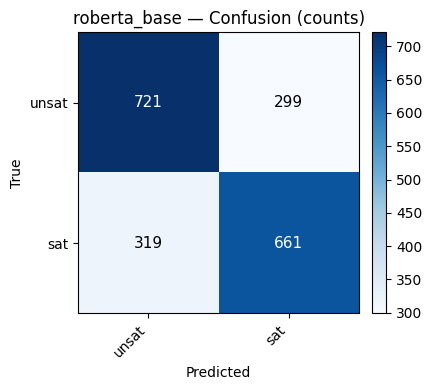

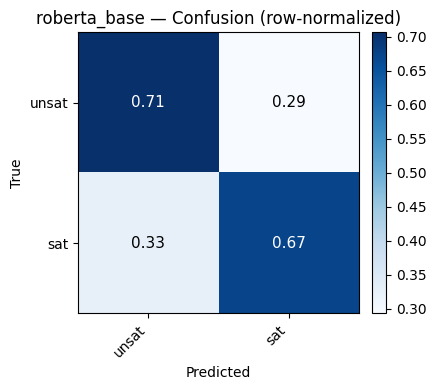

In [2]:
# ▶️ Run ONE model at a time on the syllogistic dataset
# Pick ONE: "bert", "roberta", "gpt4", or "local_lm" (no API key needed)
MODEL_TO_RUN = "roberta"   # ← change this

# ================= Setup & upload =================
# from google.colab import files
# uploaded = files.upload()  # choose your syllogistic CSV (must have 'sentences' and 'sat' or 'label')

CSV_NAME         = "fragment_S.csv"
TEXT_MAX_LEN     = 256
NUM_EPOCHS       = 3
LR               = 2e-5
TRAIN_BS         = 16
EVAL_BS          = 32
WARMUP_RATIO     = 0.06
WEIGHT_DECAY     = 0.01
RANDOM_STATE     = 42
CLASS_NAMES      = ["unsat","sat"]

# For GPT-4 zero-shot:
OPENAI_MODEL     = "gpt-4o"
EVAL_LIMIT_API   = None   # set e.g. 200 to limit GPT-4 eval size

# ================= Imports & helpers =================
import os, json, ast, re, shutil
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score

OUTDIR = Path("one_model_run"); OUTDIR.mkdir(exist_ok=True, parents=True)

SEP_TOKEN = "[SEP]"

def normalize_label(v):
    if isinstance(v,str):
        s=v.strip().lower()
        if s in {"sat","satisfiable","1","true"}: return 1
        if s in {"unsat","unsatisfiable","0","false"}: return 0
    if isinstance(v,(int,np.integer)) and v in (0,1): return int(v)
    raise ValueError(f"Bad label: {v}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x,str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums==0]=1.0
        cm_plot = cm_plot / row_sums
    plt.figure(figsize=(4.5,4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title); plt.colorbar(im, fraction=0.046, pad=0.04)
    ticks=np.arange(len(class_names))
    plt.xticks(ticks,class_names,rotation=45,ha='right'); plt.yticks(ticks,class_names)
    thr = cm_plot.max()/2 if cm_plot.max()>0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i,j]:.2f}" if normalize else f"{int(cm_plot[i,j])}"
            plt.text(j,i,val,ha="center",va="center",color="white" if cm_plot[i,j]>thr else "black",fontsize=11)
    plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ================= Load data =================
df = pd.read_csv(CSV_NAME)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
assert label_col is not None, "Expected 'label' or 'sat' column."
assert "sentences" in df.columns, "Expected 'sentences' column."

df["y"]    = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

X_train, X_val, y_train, y_val = train_test_split(
    df["text"].tolist(), df["y"].to_numpy(),
    test_size=0.2, stratify=df["y"].to_numpy(), random_state=RANDOM_STATE
)

print(f"Train={len(X_train)} | Val={len(X_val)} | Val sat rate={np.mean(y_val):.3f}")

# ================= Branch per model =================
if MODEL_TO_RUN in {"bert","roberta"}:
    # Try to import 🤗; if missing, install minimal deps
    try:
        import torch
        from datasets import Dataset
        from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                                  DataCollatorWithPadding, TrainingArguments, Trainer, set_seed)
    except Exception:
        !pip -q install "transformers>=4.30.0" "datasets>=2.14.0" "accelerate>=0.21.0" evaluate
        import torch
        from datasets import Dataset
        from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                                  DataCollatorWithPadding, TrainingArguments, Trainer, set_seed)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8

    model_name = "bert-base-uncased" if MODEL_TO_RUN=="bert" else "roberta-base"
    outname    = f"{MODEL_TO_RUN}_base"

    # Build datasets and KEEP labels
    train_ds = Dataset.from_dict({"text": X_train, "label": y_train}).rename_column("label","labels")
    val_ds   = Dataset.from_dict({"text": X_val,   "label": y_val}).rename_column("label","labels")

    set_seed(RANDOM_STATE)

    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    def tok_fn(batch): return tok(batch["text"], truncation=True, max_length=TEXT_MAX_LEN)

    # Remove ONLY 'text' so 'labels' stays
    enc_train = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
    enc_val   = val_ds.map(tok_fn,   batched=True, remove_columns=["text"])

    collator  = DataCollatorWithPadding(tokenizer=tok)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2, problem_type="single_label_classification"
    ).to(device)

    # ---- Compatibility shim for TrainingArguments (handles old/new versions) ----
    import inspect
    def make_training_args(out_dir, bf16=False):
        from transformers import TrainingArguments
        want = dict(
            output_dir=str(out_dir),
            learning_rate=LR,
            per_device_train_batch_size=TRAIN_BS,
            per_device_eval_batch_size=EVAL_BS,
            num_train_epochs=NUM_EPOCHS,
            weight_decay=WEIGHT_DECAY,
            warmup_ratio=WARMUP_RATIO,
            logging_steps=50,
            seed=RANDOM_STATE,
            report_to=[],
            evaluation_strategy="epoch",  # old name (may not exist)
            eval_strategy="epoch",        # new name (≥4.46)
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            fp16=(torch.cuda.is_available() and not bf16),
            bf16=bf16
        )
        params = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
        safe = {k: v for k, v in want.items() if k in params}
        return TrainingArguments(**safe)

    args = make_training_args(OUTDIR / outname, bf16=bf16)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(-1)
        acc = accuracy_score(labels, preds)
        p, r, f1m, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "f1_macro": f1m, "precision_macro": p, "recall_macro": r}

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=enc_train,
        eval_dataset=enc_val,
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    trainer.train()

    # Evaluate
    preds = trainer.predict(enc_val)
    y_pred = preds.predictions.argmax(-1)

    print(f"\nValidation report — {outname}:")
    print(classification_report(y_val, y_pred, digits=4, target_names=CLASS_NAMES))
    cm = confusion_matrix(y_val, y_pred, labels=[0,1])
    plot_cm(cm, CLASS_NAMES, f"{outname} — Confusion (counts)", normalize=False, save_path=OUTDIR/f"cm_{outname}_counts.png")
    plot_cm(cm, CLASS_NAMES, f"{outname} — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/f"cm_{outname}_normalized.png")

elif MODEL_TO_RUN == "gpt4":
    # Zero-shot via OpenAI API
    def normalize_api_label(txt: str):
        t = (txt or "").strip().lower()
        t0 = re.split(r'[\s\.\,\n]', t)[0]
        if "unsat" in t0 or t0 == "0": return 0
        if "sat"   in t0 or t0 == "1": return 1
        if "unsat" in t: return 0
        if "sat"   in t: return 1
        return None

    def gpt4_call(prompt: str):
        key = os.getenv("OPENAI_API_KEY")
        if not key:
            return "sat"  # safe default if no key set
        try:
            !pip -q install --upgrade openai
            from openai import OpenAI
            client = OpenAI(api_key=key)
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[
                    {"role":"system","content":"You are a concise, deterministic binary classifier."},
                    {"role":"user","content":prompt}
                ],
                temperature=0,
            )
            return resp.choices[0].message.content.strip()
        except Exception as e:
            print("OpenAI error:", e); return None

    texts = X_val if EVAL_LIMIT_API is None else X_val[:EVAL_LIMIT_API]
    ys    = y_val if EVAL_LIMIT_API is None else y_val[:EVAL_LIMIT_API]
    preds = []
    for i, s in enumerate(texts):
        prompt = ("You are a formal-logic classifier. Decide if the fragment is SATISFIABLE (sat) or "
                  "UNSATISFIABLE (unsat). Return exactly one word: 'sat' or 'unsat'.\n\nFragment:\n" + s)
        out = gpt4_call(prompt)
        lab = normalize_api_label(out or "")
        preds.append(1 if lab is None else lab)
        if (i+1)%20==0: print(f"  processed {i+1}/{len(texts)}")

    print("\nValidation report — gpt4_zeroshot:")
    print(classification_report(ys, preds, digits=4, target_names=CLASS_NAMES))
    cm = confusion_matrix(ys, preds, labels=[0,1])
    plot_cm(cm, CLASS_NAMES, "gpt4_zeroshot — Confusion (counts)", normalize=False, save_path=OUTDIR/"cm_gpt4_counts.png")
    plot_cm(cm, CLASS_NAMES, "gpt4_zeroshot — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/"cm_gpt4_normalized.png")

elif MODEL_TO_RUN == "local_lm":
    # Local LLM baseline with A/B forced choice, balanced few-shot, and voting.
    # Tries Qwen2.5 (preferred). If it fails (old transformers), falls back to Phi-3-mini.
    import torch, random, re
    from transformers import AutoTokenizer, AutoModelForCausalLM

    def load_chat_model(repo_id, compute_dtype):
        tok = AutoTokenizer.from_pretrained(repo_id, use_fast=True, trust_remote_code=True)
        if tok.pad_token_id is None:
            tok.pad_token_id = tok.eos_token_id
        model = AutoModelForCausalLM.from_pretrained(
            repo_id,
            trust_remote_code=True,
            device_map="auto" if torch.cuda.is_available() else None,
            torch_dtype=compute_dtype,
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=compute_dtype,
        )
        return tok, model

    device = "cuda" if torch.cuda.is_available() else "cpu"
    compute_dtype = torch.float16 if device == "cuda" else torch.float32

    try:
        LM_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
        tok, model = load_chat_model(LM_NAME, compute_dtype)
        print("Loaded:", LM_NAME)
    except Exception as e:
        print("Qwen2.5 load failed, falling back to Phi-3-mini. Error:", e)
        LM_NAME = "microsoft/Phi-3-mini-4k-instruct"
        tok, model = load_chat_model(LM_NAME, compute_dtype)
        print("Loaded:", LM_NAME)

    # ----- Few-shot builder (balanced: k per class) -----
    def build_fewshot(X, y, k=4, seed=42):
        rng = random.Random(seed)
        idx0 = [i for i,t in enumerate(y) if t == 0]
        idx1 = [i for i,t in enumerate(y) if t == 1]
        rng.shuffle(idx0); rng.shuffle(idx1)
        shots = []
        for i in idx0[:k]: shots.append((X[i], "A"))  # A = unsat
        for i in idx1[:k]: shots.append((X[i], "B"))  # B = sat
        rng.shuffle(shots)
        return shots

    def make_messages(fewshot, fragment):
        sys_msg = (
            "You are a formal-logic classifier. Decide if a fragment is UNSATISFIABLE or SATISFIABLE.\n"
            "Use a forced choice: A = unsat, B = sat.\n"
            "Reply with exactly one character: 'A' or 'B'. No explanation."
        )
        messages = [{"role":"system","content":sys_msg}]
        for s, lab in fewshot:
            messages.append({"role":"user","content": f"Fragment:\n{s}\n\nAnswer (A or B):"})
            messages.append({"role":"assistant","content": lab})
        messages.append({"role":"user","content": f"Fragment:\n{fragment}\n\nAnswer (A or B):"})
        return messages

    def run_one(messages, max_new_tokens=2, temperature=0.1, top_p=0.95):
        # Use chat template if available; else plain text
        try:
            prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        except Exception:
            prompt = "\n\n".join([f"[{m['role'].upper()}]\n{m['content']}" for m in messages] + ["[ASSISTANT]\n"])
        inputs = tok(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            out = model.generate(
                **inputs,
                max_new_tokens=2,
                do_sample=(temperature > 0),
                temperature=temperature,
                top_p=top_p,
                pad_token_id=tok.pad_token_id,
                eos_token_id=tok.eos_token_id,
            )
        gen = tok.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
        m = re.search(r"\b([AB])\b", gen.strip())
        return m.group(1) if m else None

    def ab_to_label(ab):
        return 0 if ab == "A" else 1 if ab == "B" else None

    FEWSHOT_K = 4
    VOTES     = 3
    TEMPERATURE = 0.1
    TOP_P       = 0.95

    preds = []
    base_seeds = [42, 777, 2025]
    for i, frag in enumerate(X_val):
        votes = []
        for s in base_seeds[:VOTES]:
            shots = build_fewshot(X_train, y_train, k=FEWSHOT_K, seed=s + i)
            ab = run_one(make_messages(shots, frag), temperature=TEMPERATURE, top_p=TOP_P)
            lab = ab_to_label(ab)
            votes.append(1 if lab is None else lab)  # default to 'sat' if parse failed
        pred = int(round(sum(votes) / len(votes)))
        preds.append(pred)
        if (i+1) % 20 == 0:
            print(f"  processed {i+1}/{len(X_val)}")

    print(f"\nValidation report — local_lm ({LM_NAME}, 4-bit, few-shot, A/B, vote):")
    print(classification_report(y_val, preds, digits=4, target_names=CLASS_NAMES))
    cm = confusion_matrix(y_val, preds, labels=[0,1])
    plot_cm(cm, CLASS_NAMES, "local_lm — Confusion (counts)", normalize=False, save_path=OUTDIR/"cm_local_counts.png")
    plot_cm(cm, CLASS_NAMES, "local_lm — Confusion (row-normalized)", normalize=True, save_path=OUTDIR/"cm_local_normalized.png")

else:
    raise ValueError("MODEL_TO_RUN must be one of: 'bert', 'roberta', 'gpt4', 'local_lm'")
